In [1]:
import os
import glob
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
import imblearn

In [2]:
filename = 'tpot_221115 948pm SMOTE DefaultTPOT+ AUC'

# Cleaning data

### Victor_img_df

In [3]:
victor_img_df = pd.read_csv('/Users/travistang/Documents/TorchScene/data/csv/fake_merchant_tagging_combined_set_result.csv',index_col = [0])
victor_img_df = victor_img_df.query('outlet_photo_tagging!="Empty"') # Removing empty images
victor_img_df['restaurant_cart_inappropriateness_label'] = victor_img_df['prediction_score'] < 0.6
victor_img_df['victor_label_inappropriate_flag'] = victor_img_df.apply(lambda row: 1 if row['outlet_photo_tagging'] == '1' else 0, axis=1) 
# Note that outlet_photo_tagging == 1 are those that are tagged as bad by victor because they are fake. the rest are actually good labels

# get group
victor_img_df_val_set = pd.read_csv('/Users/travistang/Documents/TorchScene/result/intermediate/victor_img_tpot_df_result tpot_221109 122pm.csv')
victor_img_df = victor_img_df.merge(victor_img_df_val_set[['saudagar_id','group']], how ='left', on ='saudagar_id')
victor_img_df['group'] = victor_img_df['group'].fillna(victor_img_df['set'])

# if a saudagar_id is in validation and test, keep it in validation and drop it from test
victor_img_df = victor_img_df.sort_values('set',ascending=True).drop_duplicates(subset=['source','saudagar_id'],keep='last') 

df_prediction_result = pd.read_csv('/Users/travistang/Documents/TorchScene/result/csv/victor_set_resnet18.csv', index_col = [0])
victor_img_df = victor_img_df.merge(df_prediction_result['pred'], how='inner', left_on = 'saudagar_id', right_index=True)

# Get the validation set only so I don't get biased
victor_img_val_df = victor_img_df.query('set == "val"')

victor_img_df

,source,entity_id,saudagar_id,last_action,last_rule,last_sanction_datetime,outlet_photo_url,bank_acc_name,bank_acc_no,cnt_diff_entity_shared_bank_acc,...,victor_label_inappropriate_flag,restaurant_cart_inappropriateness_label,random,set,restaurant_store_cart_false_positive,restaurant_store_cart_false_negative,label,prediction_score,group,pred
0,data,0012s00000NXGa6AAH,G285231232,SuspendMerchantPayout,IBT-M52-009-10A,2022-07-12 9:33:43,https://api.gobiz.co.id/v1/onboardings/data/SF...,MOHAMAD RIDWAN,8.330079e+09,302.0,...,1,True,0.904060,test,0.0,0.0,NaN,0.000354,test,burial_chamber 69
2260,good_photos,NaN,G805388509,NaN,NaN,NaN,https://api.gobiz.co.id/v1/onboardings/data/SF...,NaN,NaN,NaN,...,0,False,0.575984,test,0.0,1.0,NaN,0.999973,test,kindergarden_classroom 202
2261,good_photos,NaN,G024140195,NaN,NaN,NaN,https://api.gobiz.co.id/v1/onboardings/data/SF...,NaN,NaN,NaN,...,0,False,0.575580,test,0.0,1.0,NaN,0.996800,test,bar 39
2262,good_photos,NaN,G268180486,NaN,NaN,NaN,https://api.gobiz.co.id/v1/onboardings/data/SF...,NaN,NaN,NaN,...,1,False,0.688902,test,0.0,1.0,NaN,0.999392,test,outdoor 256
2268,good_photos,NaN,G290852858,NaN,NaN,NaN,https://api.gobiz.co.id/v1/onboardings/data/SF...,NaN,NaN,NaN,...,0,False,0.916971,test,0.0,0.0,NaN,0.999991,test,ticket_booth 332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2414,good_photos,NaN,G318439890,NaN,NaN,NaN,https://api.gobiz.co.id/v1/onboardings/data/SF...,NaN,NaN,NaN,...,0,False,0.333878,val,0.0,0.0,NaN,0.999969,val_train,ticket_booth 332
836,data,0012s00000L6Dq9AAF,G559142822,SuspendMerchantGoResto,IBT-M52-015A,2022-08-25 10:45:04,https://api.midtrans.com/v1/onboardings/data/S...,CHANTIKA ALWA PUTRI HEDI,2.316349e+08,4.0,...,1,False,0.269292,val,NaN,NaN,NaN,0.759632,val_train,living_room 215
2416,good_photos,NaN,G854199120,NaN,NaN,NaN,https://api.gobiz.co.id/v1/onboardings/data/SF...,NaN,NaN,NaN,...,1,False,0.260184,val,0.0,1.0,NaN,0.992157,val_train,roof_garden 290
2417,good_photos,NaN,G028282079,NaN,NaN,NaN,https://api.gobiz.co.id/v1/onboardings/data/SF...,NaN,NaN,NaN,...,0,False,0.118239,val,0.0,1.0,NaN,0.999997,val_train,loading_dock 216


In [4]:
victor_img_df.groupby(['outlet_photo_tagging']).count()['source']

outlet_photo_tagging
0    1318
1    2031
2     623
3      10
Name: source, dtype: int64

In [5]:
victor_img_df.groupby(['group','victor_label_inappropriate_flag']).count()['source']

group      victor_label_inappropriate_flag
test       0                                   947
           1                                  1013
val_test   0                                   254
           1                                   252
val_train  0                                   750
           1                                   766
Name: source, dtype: int64

In [6]:
victor_img_df[victor_img_df['restaurant_cart_inappropriateness_label'].isna()]

,source,entity_id,saudagar_id,last_action,last_rule,last_sanction_datetime,outlet_photo_url,bank_acc_name,bank_acc_no,cnt_diff_entity_shared_bank_acc,...,victor_label_inappropriate_flag,restaurant_cart_inappropriateness_label,random,set,restaurant_store_cart_false_positive,restaurant_store_cart_false_negative,label,prediction_score,group,pred


In [7]:
victor_img_df.columns

Index(['source', 'entity_id', 'saudagar_id', 'last_action', 'last_rule',
       'last_sanction_datetime', 'outlet_photo_url', 'bank_acc_name',
       'bank_acc_no', 'cnt_diff_entity_shared_bank_acc',
       'diff_entity_id_shared_bank_acc',
       'cnt_diff_entity_outlet_shared_bank_acc',
       'diff_entity_outlet_id_shared_bank_acc', 'gofood_id', 'cnt_all_order',
       'sum_gmv_all_order', 'cnt_co', 'sum_gmv_co', 'cnt_maf_defect_order',
       'sum_gmv_maf_defect_order', 'cnt_cadf', 'sum_gmv_cadf', 'percent_co',
       'percent_good_order', 'percent_bad_order', 'photo',
       'outlet_photo_tagging', 'flag_fake_merchant',
       'victor_label_inappropriate_flag',
       'restaurant_cart_inappropriateness_label', 'random', 'set',
       'restaurant_store_cart_false_positive',
       'restaurant_store_cart_false_negative', 'label', 'prediction_score',
       'group', 'pred'],
      dtype='object')

### Get Oct2022_data

In [8]:
# Read travis' labels from oct2022 set
oct2022_df = pd.read_csv('/Users/travistang/Documents/TorchScene/data/labels/Oct2022_TravisLabel.csv')

# Preprocess victor's label
victor_new_df = pd.read_csv('/Users/travistang/Documents/TorchScene/data/labels/Travis Fake_Merchant_Tagging_2022 - Copy of ML training set addition 2.csv').drop(columns = ['random','set'])
victor_new_df['victor_label_inappropriate_flag'] = victor_new_df.apply(lambda row: 1 if row['victor_label_inappropriate_flag'] == '1' else 0, axis=1)  # Note that outlet_photo_tagging == 1 are those that are tagged as bad by victor because they are fake. the rest are actually good labels

# Get victor's label if travis has not labelled
oct2022_df = oct2022_df.merge(victor_new_df, how = 'left', on = 'restaurant_photo_url')
oct2022_df['travis_inappropriate_label'].fillna(oct2022_df['victor_label_inappropriate_flag'], inplace=True)

# Get the embedding for oct2022 set
df_prediction_result_oct2022_gooddata = pd.read_csv('/Users/travistang/Documents/TorchScene/result/intermediate/resnet18/oct2022_gooddata_resnet18.csv', index_col = [0])
df_prediction_result_oct2022_baddata = pd.read_csv('/Users/travistang/Documents/TorchScene/result/intermediate/resnet18/oct2022_baddata_resnet18.csv', index_col = [0])

df_prediction_result_oct2022 = pd.concat([df_prediction_result_oct2022_gooddata, df_prediction_result_oct2022_baddata])

df_prediction_result_oct2022 = df_prediction_result_oct2022.merge(oct2022_df[['outlet_id','travis_inappropriate_label','group']], 
                                    how = 'left', left_index=True,right_on='outlet_id')

df_prediction_result_oct2022.set_index('outlet_id')

# Drop images that have not been labelled
df_prediction_result_oct2022.dropna(inplace=True)


In [9]:
df_prediction_result_oct2022

,airfield 0,airplane_cabin 1,airport_terminal 2,alcove 3,alley 4,amphitheater 5,amusement_arcade 6,amusement_park 7,outdoor 8,aquarium 9,...,wet_bar 358,wheat_field 359,wind_farm 360,windmill 361,yard 362,youth_hostel 363,zen_garden 364,outlet_id,travis_inappropriate_label,group
8739,1.175332e-06,5.057530e-06,0.000076,1.025874e-04,0.000170,1.486519e-04,0.000595,0.001543,1.816568e-05,0.000050,...,0.000060,3.128750e-06,9.179776e-06,1.101525e-05,2.041509e-03,0.000012,4.518936e-05,G000051136,0.0,train
15113,1.970256e-06,2.253714e-05,0.000921,1.132516e-05,0.001191,1.095202e-04,0.000144,0.010354,3.195454e-04,0.000720,...,0.000061,2.209334e-06,1.783030e-05,3.196685e-05,7.799471e-04,0.000025,2.635096e-04,G000162899,0.0,train
26410,2.726324e-06,6.312387e-04,0.000017,1.223479e-02,0.000304,6.293109e-06,0.000534,0.000039,2.232212e-05,0.000116,...,0.000529,2.561831e-06,6.468579e-06,1.141056e-05,1.837652e-05,0.006582,1.709939e-04,G000224606,1.0,train
2207,2.137902e-08,1.091339e-06,0.000067,9.194782e-07,0.000004,9.634322e-07,0.008203,0.001622,1.499786e-07,0.000023,...,0.000015,2.604203e-08,5.356325e-08,1.718631e-07,5.244693e-07,0.000004,8.652056e-08,G000224896,0.0,train
8297,4.326732e-08,1.801121e-07,0.000005,4.614314e-07,0.000005,3.569006e-07,0.025274,0.000390,2.512259e-07,0.000014,...,0.000007,9.525789e-08,7.603673e-08,1.474809e-07,3.116443e-06,0.000001,3.905017e-08,G000370147,0.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30565,4.026394e-06,7.805059e-04,0.000207,8.751875e-03,0.003511,1.261907e-05,0.000161,0.000054,1.577824e-05,0.001119,...,0.001056,2.119998e-05,2.131157e-05,1.032646e-05,1.803221e-04,0.005164,1.103344e-03,G987336045,1.0,train
26056,1.040386e-06,5.661240e-04,0.000361,1.985723e-04,0.001025,3.115472e-06,0.001498,0.000154,2.270017e-06,0.000104,...,0.000053,5.551453e-07,6.444111e-07,5.649167e-07,1.306322e-05,0.001769,5.651703e-06,G991154114,1.0,train
30696,4.006243e-04,2.085423e-05,0.000067,8.886862e-04,0.000014,8.098442e-05,0.000014,0.000221,4.211369e-05,0.000972,...,0.000155,1.206198e-03,2.263173e-03,1.173708e-03,2.118064e-04,0.000106,1.086916e-03,G993559621,1.0,train
30729,1.028183e-04,4.148399e-05,0.000122,6.808520e-03,0.000256,7.076355e-05,0.000031,0.000144,1.150000e-04,0.000743,...,0.000211,2.043070e-04,6.766088e-04,2.385151e-04,4.731342e-04,0.000295,5.668707e-04,G996745489,1.0,train


In [10]:
df_prediction_result_oct2022.groupby(['group','travis_inappropriate_label']).count()['outlet_id']

group  travis_inappropriate_label
train  0.0                           18933
       1.0                            4276
val    0.0                            2095
       1.0                             420
Name: outlet_id, dtype: int64

# Get Baseline Performance 

In [11]:
print("Train Set performance")
print(classification_report(victor_img_df.query("group == 'val_train'")['victor_label_inappropriate_flag'],
                            victor_img_df.query("group == 'val_train'")['restaurant_cart_inappropriateness_label']))

print("Validation Set performance")
print(classification_report(victor_img_df.query("group == 'val_test'")['victor_label_inappropriate_flag'],
                            victor_img_df.query("group == 'val_test'")['restaurant_cart_inappropriateness_label']))


print("Test Set performance")
print(classification_report(victor_img_df.query("group == 'test'")['victor_label_inappropriate_flag'],
                            victor_img_df.query("group == 'test'")['restaurant_cart_inappropriateness_label']))


Train Set performance
              precision    recall  f1-score   support

           0       0.63      0.98      0.77       750
           1       0.96      0.44      0.61       766

    accuracy                           0.71      1516
   macro avg       0.80      0.71      0.69      1516
weighted avg       0.80      0.71      0.69      1516

Validation Set performance
              precision    recall  f1-score   support

           0       0.65      0.98      0.78       254
           1       0.97      0.46      0.62       252

    accuracy                           0.72       506
   macro avg       0.81      0.72      0.70       506
weighted avg       0.81      0.72      0.70       506

Test Set performance
              precision    recall  f1-score   support

           0       0.62      0.98      0.76       947
           1       0.96      0.44      0.61      1013

    accuracy                           0.70      1960
   macro avg       0.79      0.71      0.68      1960
weig

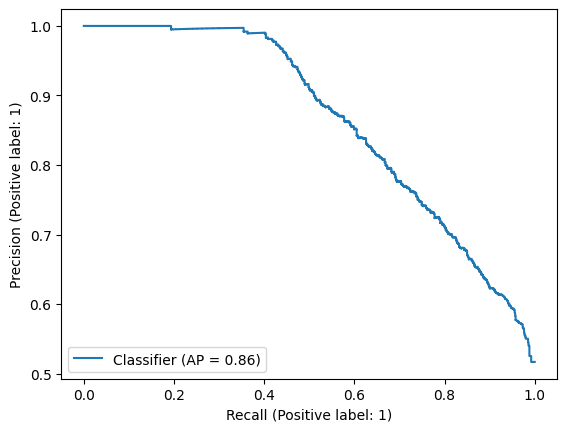

In [12]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(victor_img_df.query("group == 'test'")['victor_label_inappropriate_flag'],
                                        1- victor_img_df.query("group == 'test'")['prediction_score'])

# Exploring the Validation Set

In [13]:
# Finding categories that are highly correlated with inappropriate categories
victor_img_val_explore_str = victor_img_val_df.pivot_table(index = ['pred','restaurant_cart_inappropriateness_label'], columns = 'victor_label_inappropriate_flag', aggfunc = len)['source']

print(victor_img_val_explore_str.to_string())

victor_label_inappropriate_flag                                         0     1
pred                       restaurant_cart_inappropriateness_label             
airplane_cabin 1           False                                      1.0   NaN
alcove 3                   False                                      2.0   6.0
                           True                                       1.0   5.0
alley 4                    False                                      3.0   7.0
amusement_arcade 6         False                                     39.0   NaN
amusement_park 7           False                                      4.0   1.0
aquarium 9                 True                                       NaN   8.0
archive 14                 False                                      1.0   1.0
                           True                                       NaN   7.0
art_gallery 19             False                                      NaN   2.0
art_school 20              False        

# Using TPOT to train a decision tree classifier for the 365-length vector

### Creating TPOT set for victor_img_df

In [14]:
df_prediction_result_oct2022.columns

Index(['airfield 0', 'airplane_cabin 1', 'airport_terminal 2', 'alcove 3',
       'alley 4', 'amphitheater 5', 'amusement_arcade 6', 'amusement_park 7',
       'outdoor 8', 'aquarium 9',
       ...
       'wet_bar 358', 'wheat_field 359', 'wind_farm 360', 'windmill 361',
       'yard 362', 'youth_hostel 363', 'zen_garden 364', 'outlet_id',
       'travis_inappropriate_label', 'group'],
      dtype='object', length=368)

In [15]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split

#Creating a dataframe for tpot only
oct2022_tpot_df = df_prediction_result_oct2022.copy()
oct2022_tpot_df = oct2022_tpot_df.set_index('outlet_id')
oct2022_tpot_df = oct2022_tpot_df.rename(columns = {'travis_inappropriate_label':'inappropriate_flag'})

target_col = 'inappropriate_flag' #restaurant_store_cart_false_positive

# Making sure this is idempotent
oct_2022_X_train = oct2022_tpot_df.query('group == "train"').drop(columns=[target_col,'group'])
oct_2022_y_train = oct2022_tpot_df.query('group == "train"').drop(columns=['group'])[target_col]
oct_2022_X_test = oct2022_tpot_df.query('group == "val"').drop(columns=[target_col,'group'])
oct_2022_y_test = oct2022_tpot_df.query('group == "val"').drop(columns=['group'])[target_col]

/Users/travistang/opt/anaconda3/envs/torch-scene/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Creating TPOT Set for Oct_2022

In [16]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split

#Creating a dataframe for tpot only
victor_img_tpot_df = victor_img_df.merge(df_prediction_result.drop(columns=['pred']), how='left', left_on = 'saudagar_id', right_index=True)
victor_img_tpot_df = victor_img_tpot_df.dropna(subset=['airfield 0']) 
victor_img_tpot_df = victor_img_tpot_df.set_index('saudagar_id')
victor_img_tpot_df = victor_img_tpot_df.query('set == "val"')

victor_img_tpot_df = victor_img_tpot_df.drop(columns = ['source', 'entity_id', 'last_action', 'last_rule',
       'last_sanction_datetime', 'outlet_photo_url', 'bank_acc_name',
       'bank_acc_no', 'cnt_diff_entity_shared_bank_acc',
       'diff_entity_id_shared_bank_acc',
       'cnt_diff_entity_outlet_shared_bank_acc',
       'diff_entity_outlet_id_shared_bank_acc', 'gofood_id', 'cnt_all_order',
       'sum_gmv_all_order', 'cnt_co', 'sum_gmv_co', 'cnt_maf_defect_order',
       'sum_gmv_maf_defect_order', 'cnt_cadf', 'sum_gmv_cadf', 'percent_co',
       'percent_good_order', 'percent_bad_order', 'photo',
       'outlet_photo_tagging', 'flag_fake_merchant', 'prediction_score',
       'restaurant_cart_inappropriateness_label',
       'random','set',
       'restaurant_store_cart_false_positive','restaurant_store_cart_false_negative','label','pred','group'])

victor_img_tpot_df = victor_img_tpot_df.rename(columns = {'victor_label_inappropriate_flag': 'inappropriate_flag'})

target_col = 'inappropriate_flag' #restaurant_store_cart_false_positive

X_train, X_test, y_train, y_test = train_test_split(victor_img_tpot_df.drop(columns=[target_col]), 
                                                    victor_img_tpot_df[target_col],
                                                    train_size=0.75, 
                                                    test_size=0.25,
                                                    random_state=42)

# Making sure this is idempotent
# victor_img_df_val_set = pd.read_csv('/Users/travistang/Documents/TorchScene/result/intemediate/victor_img_tpot_df_result tpot_221108 122pm.csv')
# X_train = victor_img_df_val_set.query('group == "val_train"').set_index('saudagar_id').drop(columns=['victor_label_inappropriate_flag','pred','group','inappropriate_prob','outlet_photo_url','prediction_score'])
# y_train = victor_img_df_val_set.query('group == "val_train"')['victor_label_inappropriate_flag']
# X_test = victor_img_df_val_set.query('group == "val_test"').set_index('saudagar_id').drop(columns=['victor_label_inappropriate_flag','pred','group','inappropriate_prob','outlet_photo_url','prediction_score'])
# y_test = victor_img_df_val_set.query('group == "val_test"')['victor_label_inappropriate_flag']


### Merging all TPOT sets

In [17]:
oct2022_tpot_df

,airfield 0,airplane_cabin 1,airport_terminal 2,alcove 3,alley 4,amphitheater 5,amusement_arcade 6,amusement_park 7,outdoor 8,aquarium 9,...,wave 357,wet_bar 358,wheat_field 359,wind_farm 360,windmill 361,yard 362,youth_hostel 363,zen_garden 364,inappropriate_flag,group
outlet_id,,,,,,,,,,,,,,,,,,,,,
G000051136,1.175332e-06,5.057530e-06,0.000076,1.025874e-04,0.000170,1.486519e-04,0.000595,0.001543,1.816568e-05,0.000050,...,4.171371e-06,0.000060,3.128750e-06,9.179776e-06,1.101525e-05,2.041509e-03,0.000012,4.518936e-05,0.0,train
G000162899,1.970256e-06,2.253714e-05,0.000921,1.132516e-05,0.001191,1.095202e-04,0.000144,0.010354,3.195454e-04,0.000720,...,2.587163e-05,0.000061,2.209334e-06,1.783030e-05,3.196685e-05,7.799471e-04,0.000025,2.635096e-04,0.0,train
G000224606,2.726324e-06,6.312387e-04,0.000017,1.223479e-02,0.000304,6.293109e-06,0.000534,0.000039,2.232212e-05,0.000116,...,1.240791e-06,0.000529,2.561831e-06,6.468579e-06,1.141056e-05,1.837652e-05,0.006582,1.709939e-04,1.0,train
G000224896,2.137902e-08,1.091339e-06,0.000067,9.194782e-07,0.000004,9.634322e-07,0.008203,0.001622,1.499786e-07,0.000023,...,1.618801e-08,0.000015,2.604203e-08,5.356325e-08,1.718631e-07,5.244693e-07,0.000004,8.652056e-08,0.0,train
G000370147,4.326732e-08,1.801121e-07,0.000005,4.614314e-07,0.000005,3.569006e-07,0.025274,0.000390,2.512259e-07,0.000014,...,9.611183e-08,0.000007,9.525789e-08,7.603673e-08,1.474809e-07,3.116443e-06,0.000001,3.905017e-08,0.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G987336045,4.026394e-06,7.805059e-04,0.000207,8.751875e-03,0.003511,1.261907e-05,0.000161,0.000054,1.577824e-05,0.001119,...,1.310170e-05,0.001056,2.119998e-05,2.131157e-05,1.032646e-05,1.803221e-04,0.005164,1.103344e-03,1.0,train
G991154114,1.040386e-06,5.661240e-04,0.000361,1.985723e-04,0.001025,3.115472e-06,0.001498,0.000154,2.270017e-06,0.000104,...,1.065697e-06,0.000053,5.551453e-07,6.444111e-07,5.649167e-07,1.306322e-05,0.001769,5.651703e-06,1.0,train
G993559621,4.006243e-04,2.085423e-05,0.000067,8.886862e-04,0.000014,8.098442e-05,0.000014,0.000221,4.211369e-05,0.000972,...,5.038660e-03,0.000155,1.206198e-03,2.263173e-03,1.173708e-03,2.118064e-04,0.000106,1.086916e-03,1.0,train


In [18]:
victor_img_tpot_df

,inappropriate_flag,airfield 0,airplane_cabin 1,airport_terminal 2,alcove 3,alley 4,amphitheater 5,amusement_arcade 6,amusement_park 7,outdoor 8,...,waterfall 355,watering_hole 356,wave 357,wet_bar 358,wheat_field 359,wind_farm 360,windmill 361,yard 362,youth_hostel 363,zen_garden 364
saudagar_id,,,,,,,,,,,,,,,,,,,,,
G341646209,0,1.044018e-07,2.577401e-05,0.000040,0.000006,0.000024,0.000001,0.011066,0.000695,5.820605e-07,...,1.741644e-06,1.077568e-07,3.483915e-07,0.000024,2.870187e-06,1.306169e-06,5.693373e-07,0.000034,1.048400e-05,7.468568e-07
G217047851,0,2.410476e-06,9.800496e-06,0.000133,0.000055,0.000007,0.000350,0.087628,0.007391,2.080143e-06,...,2.275699e-06,1.472123e-07,9.475266e-07,0.000496,9.153538e-06,1.730458e-06,2.724099e-06,0.000015,1.501793e-05,4.521496e-06
G648689399,0,9.574789e-08,5.959731e-07,0.000004,0.001341,0.000326,0.000003,0.002135,0.000860,1.432881e-06,...,8.551498e-07,2.672232e-06,1.958193e-06,0.000147,3.143882e-06,2.087000e-06,2.049415e-06,0.002349,1.571927e-04,1.832540e-05
G308077671,1,2.117730e-05,1.337473e-06,0.000017,0.000222,0.000738,0.001019,0.000049,0.000951,1.661835e-04,...,1.117521e-05,7.726232e-05,6.282718e-06,0.000010,7.398581e-05,1.355634e-05,1.714601e-04,0.001325,4.495236e-06,1.892587e-03
G310350014,1,2.029986e-04,2.733929e-04,0.000128,0.007858,0.000063,0.000039,0.000015,0.000192,5.630489e-05,...,1.710537e-04,5.137792e-04,3.901127e-03,0.000358,1.871998e-03,5.674774e-03,2.120331e-03,0.000156,1.607973e-04,3.299310e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G318439890,0,1.360974e-08,1.452911e-07,0.000029,0.000002,0.000028,0.000001,0.008169,0.000250,1.379280e-06,...,5.132075e-07,4.678020e-07,3.754907e-07,0.000029,2.592464e-07,1.407964e-07,1.578836e-07,0.000087,4.102541e-07,1.020888e-06
G559142822,1,1.366196e-06,1.126439e-04,0.000017,0.095281,0.000139,0.000465,0.001490,0.000158,1.006817e-05,...,1.424341e-06,1.083648e-05,7.159904e-06,0.015219,6.351623e-06,7.995354e-06,6.323814e-06,0.002332,8.178752e-03,5.546323e-04
G854199120,1,1.100500e-06,1.408586e-04,0.000023,0.000789,0.006795,0.000008,0.000114,0.000400,3.663022e-04,...,1.127474e-05,3.252036e-06,1.324676e-06,0.000058,1.664062e-05,6.828315e-06,1.274918e-05,0.032430,1.040897e-05,1.680212e-03


In [19]:
tpot_df = pd.concat([oct2022_tpot_df.drop(columns=['group']),victor_img_tpot_df])

In [20]:
X_train_full = pd.concat([X_train, oct_2022_X_train])
y_train_full = pd.concat([y_train, oct_2022_y_train])
X_test = pd.concat([X_test, oct_2022_X_test])
y_test = pd.concat([y_test, oct_2022_y_test])

In [21]:
# define oversampling strategy
sample = imblearn.over_sampling.SMOTE(random_state = 42)
X_train, y_train = sample.fit_resample(X_train_full, y_train_full)

In [22]:
X_train

,airfield 0,airplane_cabin 1,airport_terminal 2,alcove 3,alley 4,amphitheater 5,amusement_arcade 6,amusement_park 7,outdoor 8,aquarium 9,...,waterfall 355,watering_hole 356,wave 357,wet_bar 358,wheat_field 359,wind_farm 360,windmill 361,yard 362,youth_hostel 363,zen_garden 364
0,2.462027e-05,0.000837,0.001400,0.038349,0.000931,0.000122,0.002155,0.000459,1.554026e-04,0.001278,...,8.094874e-06,4.614080e-06,0.000019,0.000676,0.000071,0.000211,0.000036,0.000285,0.002150,0.000455
1,1.765403e-05,0.001567,0.000829,0.002592,0.000601,0.000026,0.001119,0.000113,1.981817e-05,0.000757,...,3.846678e-06,2.682814e-06,0.000180,0.000200,0.000030,0.000050,0.000016,0.000171,0.007981,0.000049
2,8.978031e-06,0.004004,0.002261,0.000046,0.157636,0.000009,0.045003,0.003138,1.136590e-05,0.019473,...,1.468878e-06,8.886669e-08,0.000037,0.000332,0.000008,0.000015,0.000010,0.000056,0.000137,0.000003
3,6.096548e-07,0.000007,0.000029,0.000346,0.000005,0.000004,0.037924,0.000287,3.233849e-07,0.002359,...,3.473772e-06,1.532343e-06,0.000002,0.000083,0.000046,0.000009,0.000003,0.000026,0.000456,0.000014
4,4.106434e-05,0.000037,0.000310,0.001294,0.002421,0.001850,0.000153,0.001244,2.410790e-04,0.001728,...,1.321685e-04,6.051866e-05,0.000201,0.000101,0.008197,0.000974,0.000484,0.016456,0.000326,0.000276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39357,8.801716e-06,0.000143,0.000229,0.005043,0.000352,0.000152,0.000105,0.000037,3.541890e-04,0.000256,...,1.343668e-06,3.673107e-06,0.000011,0.000834,0.000009,0.000010,0.000055,0.000614,0.000178,0.000753
39358,5.363625e-05,0.000009,0.000134,0.000017,0.000081,0.000218,0.000004,0.000341,2.389008e-05,0.002335,...,1.976340e-04,9.464673e-05,0.000051,0.000031,0.010572,0.000104,0.000327,0.008746,0.000004,0.022702
39359,2.808494e-06,0.000025,0.000011,0.000843,0.015529,0.000547,0.000006,0.000034,1.557263e-03,0.000049,...,6.749314e-05,1.344898e-04,0.000030,0.000065,0.000003,0.000009,0.000015,0.008789,0.000010,0.000460
39360,3.121639e-06,0.000051,0.000154,0.000193,0.000132,0.000007,0.000010,0.000016,1.417556e-05,0.000014,...,7.232431e-07,2.333161e-07,0.000001,0.000017,0.000001,0.000002,0.000003,0.000011,0.001163,0.000011


### Training for TPOT

In [23]:
tpot_config = {

    # Classifiers
    'sklearn.naive_bayes.GaussianNB': {
    },

    'sklearn.naive_bayes.BernoulliNB': {
        'alpha': [1e-3, 1e-2, 1e-1, 1., 10., 100.],
        'fit_prior': [True, False]
    },

    'sklearn.naive_bayes.MultinomialNB': {
        'alpha': [1e-3, 1e-2, 1e-1, 1., 10., 100.],
        'fit_prior': [True, False]
    },

    'sklearn.tree.DecisionTreeClassifier': {
        'criterion': ["gini", "entropy"],
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21)
    },

    'sklearn.ensemble.ExtraTreesClassifier': {
        'n_estimators': [100],
        'criterion': ["gini", "entropy"],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    },

    # 'sklearn.ensemble.RandomForestClassifier': {
    #     'n_estimators': [100],
    #     'criterion': ["gini", "entropy"],
    #     'max_features': np.arange(0.05, 1.01, 0.05),
    #     'min_samples_split': range(2, 21),
    #     'min_samples_leaf':  range(1, 21),
    #     'bootstrap': [True, False]
    # },

    'sklearn.ensemble.GradientBoostingClassifier': {
        'n_estimators': [100],
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'subsample': np.arange(0.05, 1.01, 0.05),
        'max_features': np.arange(0.05, 1.01, 0.05)
    },

    # 'sklearn.neighbors.KNeighborsClassifier': {
    #     'n_neighbors': range(1, 101),
    #     'weights': ["uniform", "distance"],
    #     'p': [1, 2]
    # },

    'sklearn.svm.LinearSVC': {
        'penalty': ["l1", "l2"],
        'loss': ["hinge", "squared_hinge"],
        'dual': [True, False],
        'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
        'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.]
    },

    'sklearn.linear_model.LogisticRegression': {
        'penalty': ["l1", "l2"],
        'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
        'dual': [True, False]
    },

    'xgboost.XGBClassifier': {
        'n_estimators': [100],
        'max_depth': range(1, 11),
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'subsample': np.arange(0.05, 1.01, 0.05),
        'min_child_weight': range(1, 21),
        'n_jobs': [1],
        'verbosity': [0]
    },

    'sklearn.linear_model.SGDClassifier': {
        'loss': ['log', 'hinge', 'modified_huber', 'squared_hinge', 'perceptron'],
        'penalty': ['elasticnet'],
        'alpha': [0.0, 0.01, 0.001],
        'learning_rate': ['invscaling', 'constant'],
        'fit_intercept': [True, False],
        'l1_ratio': [0.25, 0.0, 1.0, 0.75, 0.5],
        'eta0': [0.1, 1.0, 0.01],
        'power_t': [0.5, 0.0, 1.0, 0.1, 100.0, 10.0, 50.0]
    },

    # 'sklearn.neural_network.MLPClassifier': {
    #     'alpha': [1e-4, 1e-3, 1e-2, 1e-1],
    #     'learning_rate_init': [1e-3, 1e-2, 1e-1, 0.5, 1.]
    # },

    # Preprocesssors
    'sklearn.preprocessing.Binarizer': {
        'threshold': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.decomposition.FastICA': {
        'tol': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.cluster.FeatureAgglomeration': {
        'linkage': ['ward', 'complete', 'average'],
        'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
    },

    'sklearn.preprocessing.MaxAbsScaler': {
    },

    'sklearn.preprocessing.MinMaxScaler': {
    },

    'sklearn.preprocessing.Normalizer': {
        'norm': ['l1', 'l2', 'max']
    },

    'sklearn.kernel_approximation.Nystroem': {
        'kernel': ['rbf', 'cosine', 'chi2', 'laplacian', 'polynomial', 'poly', 'linear', 'additive_chi2', 'sigmoid'],
        'gamma': np.arange(0.0, 1.01, 0.05),
        'n_components': range(1, 11)
    },

    'sklearn.decomposition.PCA': {
        'svd_solver': ['randomized'],
        'iterated_power': range(1, 11)
    },

    'sklearn.preprocessing.PolynomialFeatures': {
        'degree': [2],
        'include_bias': [False],
        'interaction_only': [False]
    },

    'sklearn.kernel_approximation.RBFSampler': {
        'gamma': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.preprocessing.RobustScaler': {
    },

    'sklearn.preprocessing.StandardScaler': {
    },

    'tpot.builtins.ZeroCount': {
    },

    'tpot.builtins.OneHotEncoder': {
        'minimum_fraction': [0.05, 0.1, 0.15, 0.2, 0.25],
        'sparse': [False],
        'threshold': [10]
    },

    # Selectors
    'sklearn.feature_selection.SelectFwe': {
        'alpha': np.arange(0, 0.05, 0.001),
        'score_func': {
            'sklearn.feature_selection.f_classif': None
        }
    },

    'sklearn.feature_selection.SelectPercentile': {
        'percentile': range(1, 100),
        'score_func': {
            'sklearn.feature_selection.f_classif': None
        }
    },

    'sklearn.feature_selection.VarianceThreshold': {
        'threshold': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
    },

    'sklearn.feature_selection.RFE': {
        'step': np.arange(0.05, 1.01, 0.05),
        'estimator': {
            'sklearn.ensemble.ExtraTreesClassifier': {
                'n_estimators': [100],
                'criterion': ['gini', 'entropy'],
                'max_features': np.arange(0.05, 1.01, 0.05)
            }
        }
    },

    'sklearn.feature_selection.SelectFromModel': {
        'threshold': np.arange(0, 1.01, 0.05),
        'estimator': {
            'sklearn.ensemble.ExtraTreesClassifier': {
                'n_estimators': [100],
                'criterion': ['gini', 'entropy'],
                'max_features': np.arange(0.05, 1.01, 0.05)
            }
        }
    }

}


# tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2,
#                       config_dict=tpot_config)
tpot = TPOTClassifier(generations=3, 
                      population_size=6, 
                      verbosity=3,
                      config_dict=tpot_config,
                      max_eval_time_mins = 2.5,
                      random_state=35,
                      use_dask=True,
                      subsample = 1,
                      scoring = 'roc_auc',
                      n_jobs=-1) # to enusre that we optimize precision at certain points

tpot.fit(X_train, y_train)

29 operators have been imported by TPOT.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
                                                                            
Generation 1 - Current Pareto front scores:
                                                                            
-1	0.9941618139052147	ExtraTreesClassifier(input_matrix, ExtraTreesClassifier__bootstrap=False, ExtraTreesClassifier__criterion=gini, ExtraTreesClassifier__max_features=0.45, ExtraTreesClassifier__min_samples_leaf=9, ExtraTreesClassifier__min_samples_split=7, ExtraTreesClassifier__n_estimators=100)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
                                                                            
Generation 2 - Current Pareto front scores:
                                                                      

TPOTClassifier(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                  'l1',
                                                                                  'l2',
                                                                                  'manhattan',
                                                                                  'cosine'],
                                                                     'linkage': ['ward',
                                                                                 'complete',
                                                                                 'average']},
                            'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                            'sklearn.decomposition.PCA': {'iterated_power...
                                                      'max_depth': range(1, 11),
                                                      'min_child_weight': range(1, 21),
                                                      'n_estimators': [100],
                                                      'n_jobs': [1],
                                                      'subsample': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                                                      'verbosity': [0]}},
               generations=3, max_eval_time_mins=2.5, n_jobs=-1,
               population_size=6, random_state=35, scoring='roc_auc',
               subsample=1, use_dask=True, verbosity=3)

In [ ]:
tpot

## Training a decision tree that is recommended by 

In [24]:
tpot.export(f'../tpot/{filename}.py')

In [25]:
# from sklearn.preprocessing import Normalizer
# scaler = Normalizer(norm='max').fit(X_train, y_train)
# X_train_new = scaler.transform(X_train)
# clf = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=17, min_samples_split=2)
# clf.fit(X_train_new, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=17)

In [25]:
# Making predictions on inappropriateness using classifier
# X_new = scaler.transform(tpot_df.drop(columns=['inappropriate_flag']))
tpot_df['inappropriate_prob'] = tpot.predict_proba(tpot_df.drop(columns=['inappropriate_flag']))[:,1]
tpot_df

,airfield 0,airplane_cabin 1,airport_terminal 2,alcove 3,alley 4,amphitheater 5,amusement_arcade 6,amusement_park 7,outdoor 8,aquarium 9,...,wave 357,wet_bar 358,wheat_field 359,wind_farm 360,windmill 361,yard 362,youth_hostel 363,zen_garden 364,inappropriate_flag,inappropriate_prob
G000051136,1.175332e-06,5.057530e-06,0.000076,1.025874e-04,0.000170,1.486519e-04,0.000595,0.001543,1.816568e-05,0.000050,...,4.171371e-06,0.000060,3.128750e-06,9.179776e-06,1.101525e-05,2.041509e-03,1.227790e-05,4.518936e-05,0.0,0.019053
G000162899,1.970256e-06,2.253714e-05,0.000921,1.132516e-05,0.001191,1.095202e-04,0.000144,0.010354,3.195454e-04,0.000720,...,2.587163e-05,0.000061,2.209334e-06,1.783030e-05,3.196685e-05,7.799471e-04,2.496352e-05,2.635096e-04,0.0,0.068769
G000224606,2.726324e-06,6.312387e-04,0.000017,1.223479e-02,0.000304,6.293109e-06,0.000534,0.000039,2.232212e-05,0.000116,...,1.240791e-06,0.000529,2.561831e-06,6.468579e-06,1.141056e-05,1.837652e-05,6.581865e-03,1.709939e-04,1.0,0.919140
G000224896,2.137902e-08,1.091339e-06,0.000067,9.194782e-07,0.000004,9.634322e-07,0.008203,0.001622,1.499786e-07,0.000023,...,1.618801e-08,0.000015,2.604203e-08,5.356325e-08,1.718631e-07,5.244693e-07,4.420087e-06,8.652056e-08,0.0,0.000000
G000370147,4.326732e-08,1.801121e-07,0.000005,4.614314e-07,0.000005,3.569006e-07,0.025274,0.000390,2.512259e-07,0.000014,...,9.611183e-08,0.000007,9.525789e-08,7.603673e-08,1.474809e-07,3.116443e-06,1.270820e-06,3.905017e-08,0.0,0.001111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G318439890,1.360974e-08,1.452911e-07,0.000029,1.715335e-06,0.000028,1.398123e-06,0.008169,0.000250,1.379280e-06,0.000032,...,3.754907e-07,0.000029,2.592464e-07,1.407964e-07,1.578836e-07,8.729147e-05,4.102541e-07,1.020888e-06,0.0,0.000000
G559142822,1.366196e-06,1.126439e-04,0.000017,9.528127e-02,0.000139,4.645658e-04,0.001490,0.000158,1.006817e-05,0.000961,...,7.159904e-06,0.015219,6.351623e-06,7.995354e-06,6.323814e-06,2.331974e-03,8.178752e-03,5.546323e-04,1.0,0.968663
G854199120,1.100500e-06,1.408586e-04,0.000023,7.887725e-04,0.006795,8.420592e-06,0.000114,0.000400,3.663022e-04,0.000595,...,1.324676e-06,0.000058,1.664062e-05,6.828315e-06,1.274918e-05,3.242992e-02,1.040897e-05,1.680212e-03,1.0,0.944310
G028282079,1.883490e-06,4.736675e-06,0.000044,2.738361e-03,0.002520,3.304406e-05,0.002619,0.000542,8.502529e-05,0.000323,...,5.875799e-06,0.002295,1.332362e-05,1.082608e-05,2.353229e-05,5.562219e-04,8.305259e-04,4.971078e-05,0.0,0.048417


In [37]:
# assigning group
tpot_df['group'] = ''
tpot_df.loc[tpot_df.index.isin(X_train.index),'group']='train'
tpot_df.loc[tpot_df.index.isin(X_test.index),'group']='val'

# assigning source
tpot_df['source'] = ''
tpot_df.loc[tpot_df.index.isin(victor_img_df.query('source=="data"').saudagar_id),'source']='data'
tpot_df.loc[tpot_df.index.isin(victor_img_df.query('source=="good_photos"').saudagar_id),'source']='good_photos'
tpot_df.loc[tpot_df.index.isin(df_prediction_result_oct2022_gooddata.index),'source']='oct2022_gooddata'
tpot_df.loc[tpot_df.index.isin(df_prediction_result_oct2022_baddata.index),'source']='oct2022_baddata'

# assigning set
tpot_df['set'] = ''
tpot_df.loc[tpot_df.index.isin(victor_img_df.query('source=="data"').saudagar_id),'set']='victor'
tpot_df.loc[tpot_df.index.isin(victor_img_df.query('source=="good_photos"').saudagar_id),'set']='victor'
tpot_df.loc[tpot_df.index.isin(df_prediction_result_oct2022_gooddata.index),'set']='oct2022'
tpot_df.loc[tpot_df.index.isin(df_prediction_result_oct2022_baddata.index),'set']='oct2022'

# Merging results
tpot_df['inappropriate_prob'].to_csv(f'/Users/travistang/Documents/TorchScene/result/intermediate/{filename}/tpot_df.csv')

In [38]:
# Testing on set that includes both victor set and travis labelled set
y_pred = tpot.predict(X_test)
y_score = tpot.predict_proba(X_test)[:,1]
accuracy_score(y_test, y_pred)
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      2351
         1.0       0.87      0.95      0.91       670

    accuracy                           0.96      3021
   macro avg       0.93      0.95      0.94      3021
weighted avg       0.96      0.96      0.96      3021



In [39]:
# Testing on test set of Victor's set only
X_test_victor = X_test[X_test.index.isin(tpot_df.query('set == "victor"').index)]
y_test_victor = y_test[y_test.index.isin(tpot_df.query('set == "victor"').index)]

y_pred_victor = tpot.predict(X_test_victor)
y_score_victor = tpot.predict_proba(X_test_victor)[:,1]
accuracy_score(y_test_victor, y_pred_victor)
print(classification_report(y_test_victor,y_pred_victor))


              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90       251
         1.0       0.90      0.91      0.90       247

    accuracy                           0.90       498
   macro avg       0.90      0.90      0.90       498
weighted avg       0.90      0.90      0.90       498



In [40]:
# Comparing the above performance of the classifier with that of the baseline (restaurant-cart-model)

from sklearn.metrics import accuracy_score, f1_score, classification_report

print(classification_report(victor_img_df.loc[victor_img_df.saudagar_id.isin(X_test_victor.index),"victor_label_inappropriate_flag"],
                            victor_img_df.loc[victor_img_df.saudagar_id.isin(X_test_victor.index),"prediction_score"]<0.6))


# victor_img_tpot_df.loc[victor_img_tpot_df.index.isin(X_train.index),'group']='val_train'
# victor_img_tpot_df.loc[victor_img_tpot_df.index.isin(X_test.index),'group']='val_test'

              precision    recall  f1-score   support

           0       0.65      0.96      0.78       251
           1       0.93      0.48      0.63       247

    accuracy                           0.72       498
   macro avg       0.79      0.72      0.70       498
weighted avg       0.79      0.72      0.71       498



In [41]:
# clf.predict_proba(X_test)[:,1] > 0.5
# If we puzh the threshold to be 95%, then we can make sure that the precision is a whopping 98%. That is great.
print(classification_report(y_test_victor, y_score_victor > 0.88))

              precision    recall  f1-score   support

         0.0       0.75      0.98      0.85       251
         1.0       0.97      0.66      0.79       247

    accuracy                           0.82       498
   macro avg       0.86      0.82      0.82       498
weighted avg       0.86      0.82      0.82       498



In [42]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test_victor, y_score_victor)
precision, recall, thresholds

(array([0.49598394, 0.53347732, 0.53695652, 0.53812636, 0.5404814 ,
        0.54166667, 0.54285714, 0.54405286, 0.54646018, 0.55133929,
        0.55257271, 0.55381166, 0.55505618, 0.55630631, 0.55756208,
        0.55882353, 0.56136364, 0.56392694, 0.56651376, 0.56781609,
        0.56912442, 0.5704388 , 0.57175926, 0.57308585, 0.5744186 ,
        0.57575758, 0.5771028 , 0.57845433, 0.57981221, 0.58117647,
        0.58254717, 0.58392435, 0.58530806, 0.58669834, 0.58809524,
        0.58949881, 0.59090909, 0.59232614, 0.59375   , 0.59518072,
        0.59661836, 0.59806295, 0.59951456, 0.60097324, 0.60243902,
        0.60391198, 0.60539216, 0.60687961, 0.60837438, 0.60987654,
        0.61138614, 0.61290323, 0.61442786, 0.6159601 , 0.6175    ,
        0.61904762, 0.62060302, 0.62216625, 0.62373737, 0.62531646,
        0.62690355, 0.62849873, 0.63010204, 0.63171355, 0.63333333,
        0.63496144, 0.63659794, 0.63824289, 0.63989637, 0.64155844,
        0.64322917, 0.64490862, 0.64659686, 0.64

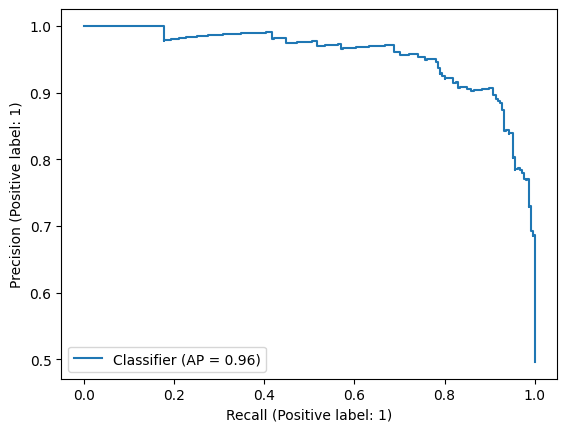

In [43]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_test_victor, y_score_victor)

# Evaluating the model on test set

In [44]:
df_test = victor_img_df.merge(df_prediction_result.drop(columns=['pred']), how='left', left_on = 'saudagar_id', right_index=True)
df_test = df_test.query('set == "test"')
df_test = df_test.dropna(subset=['airfield 0']) 
df_test = df_test.set_index('saudagar_id')

df_test = df_test.drop(columns = ['source', 'entity_id', 'last_action', 'last_rule',
       'last_sanction_datetime', 'outlet_photo_url', 'bank_acc_name',
       'bank_acc_no', 'cnt_diff_entity_shared_bank_acc',
       'diff_entity_id_shared_bank_acc',
       'cnt_diff_entity_outlet_shared_bank_acc',
       'diff_entity_outlet_id_shared_bank_acc', 'gofood_id', 'cnt_all_order',
       'sum_gmv_all_order', 'cnt_co', 'sum_gmv_co', 'cnt_maf_defect_order',
       'sum_gmv_maf_defect_order', 'cnt_cadf', 'sum_gmv_cadf', 'percent_co',
       'percent_good_order', 'percent_bad_order', 'photo',
       'outlet_photo_tagging', 'flag_fake_merchant', 'prediction_score',
       'restaurant_cart_inappropriateness_label',
       'random','set',
       'restaurant_store_cart_false_positive','restaurant_store_cart_false_negative','label','pred','set','group'])

target_col = 'victor_label_inappropriate_flag'

from sklearn.metrics import accuracy_score, f1_score, classification_report
y_pred = tpot.predict(df_test.drop(target_col,axis=1))
y_score = tpot.predict_proba(df_test.drop(target_col,axis=1))[:,1]


In [46]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
for thres in np.arange(0.5,1,0.05):
       print(f"Classification report when threshold is {thres}")
       print(classification_report(df_test[target_col],y_score > thres))


Classification report when threshold is 0.5
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       947
           1       0.92      0.88      0.90      1013

    accuracy                           0.90      1960
   macro avg       0.90      0.90      0.90      1960
weighted avg       0.90      0.90      0.90      1960

Classification report when threshold is 0.55
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       947
           1       0.92      0.86      0.89      1013

    accuracy                           0.89      1960
   macro avg       0.89      0.89      0.89      1960
weighted avg       0.89      0.89      0.89      1960

Classification report when threshold is 0.6000000000000001
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       947
           1       0.93      0.85      0.89      1013

    accuracy                      

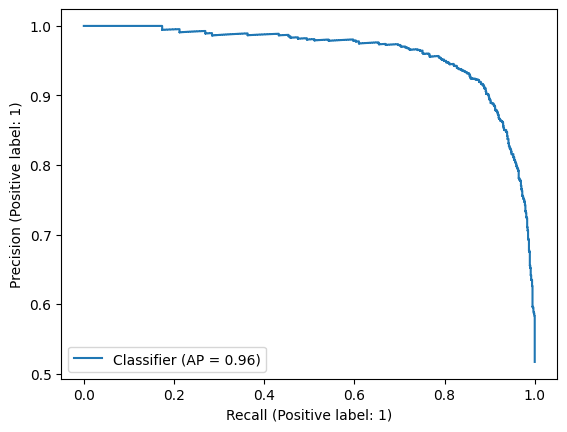

In [47]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(df_test[target_col],y_score)

In [28]:
from sklearn import tree
print(tree.export_text(tpot))

AttributeError: 'TPOTClassifier' object has no attribute 'tree_'

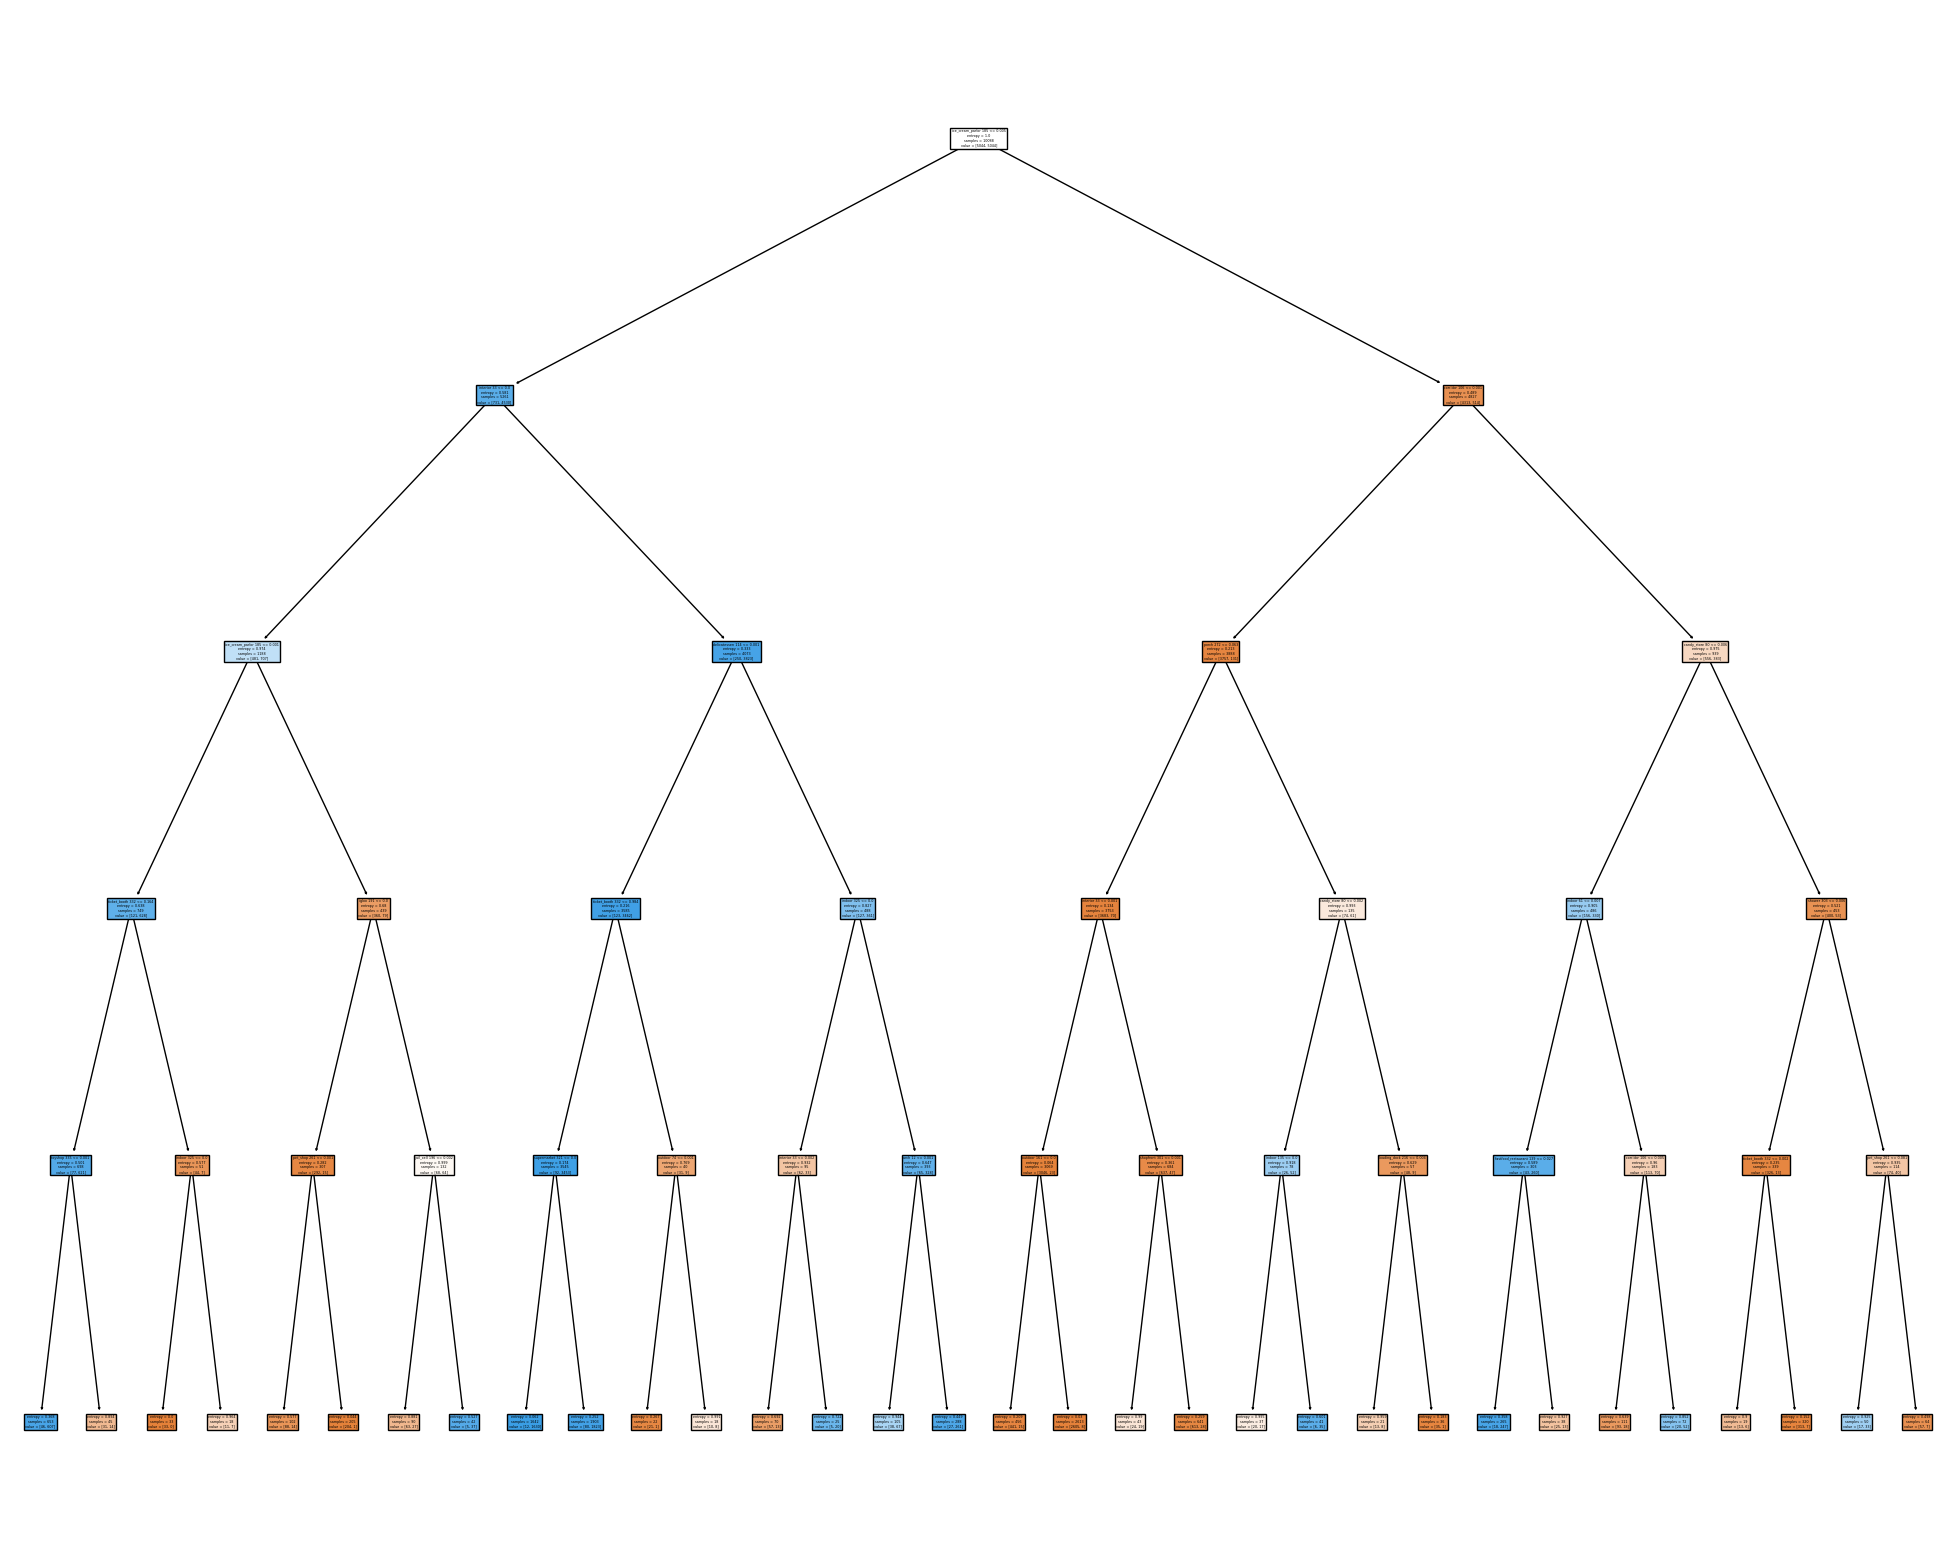

In [46]:
from sklearn import tree

scene_list = []
with open('/Users/travistang/Documents/TorchScene/categories_places365.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        scene_list.append(line.split('/')[-1].split('\n')[0])
        
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=scene_list,  
                #    class_names=iris.target_names,
                   filled=True)

<AxesSubplot: >

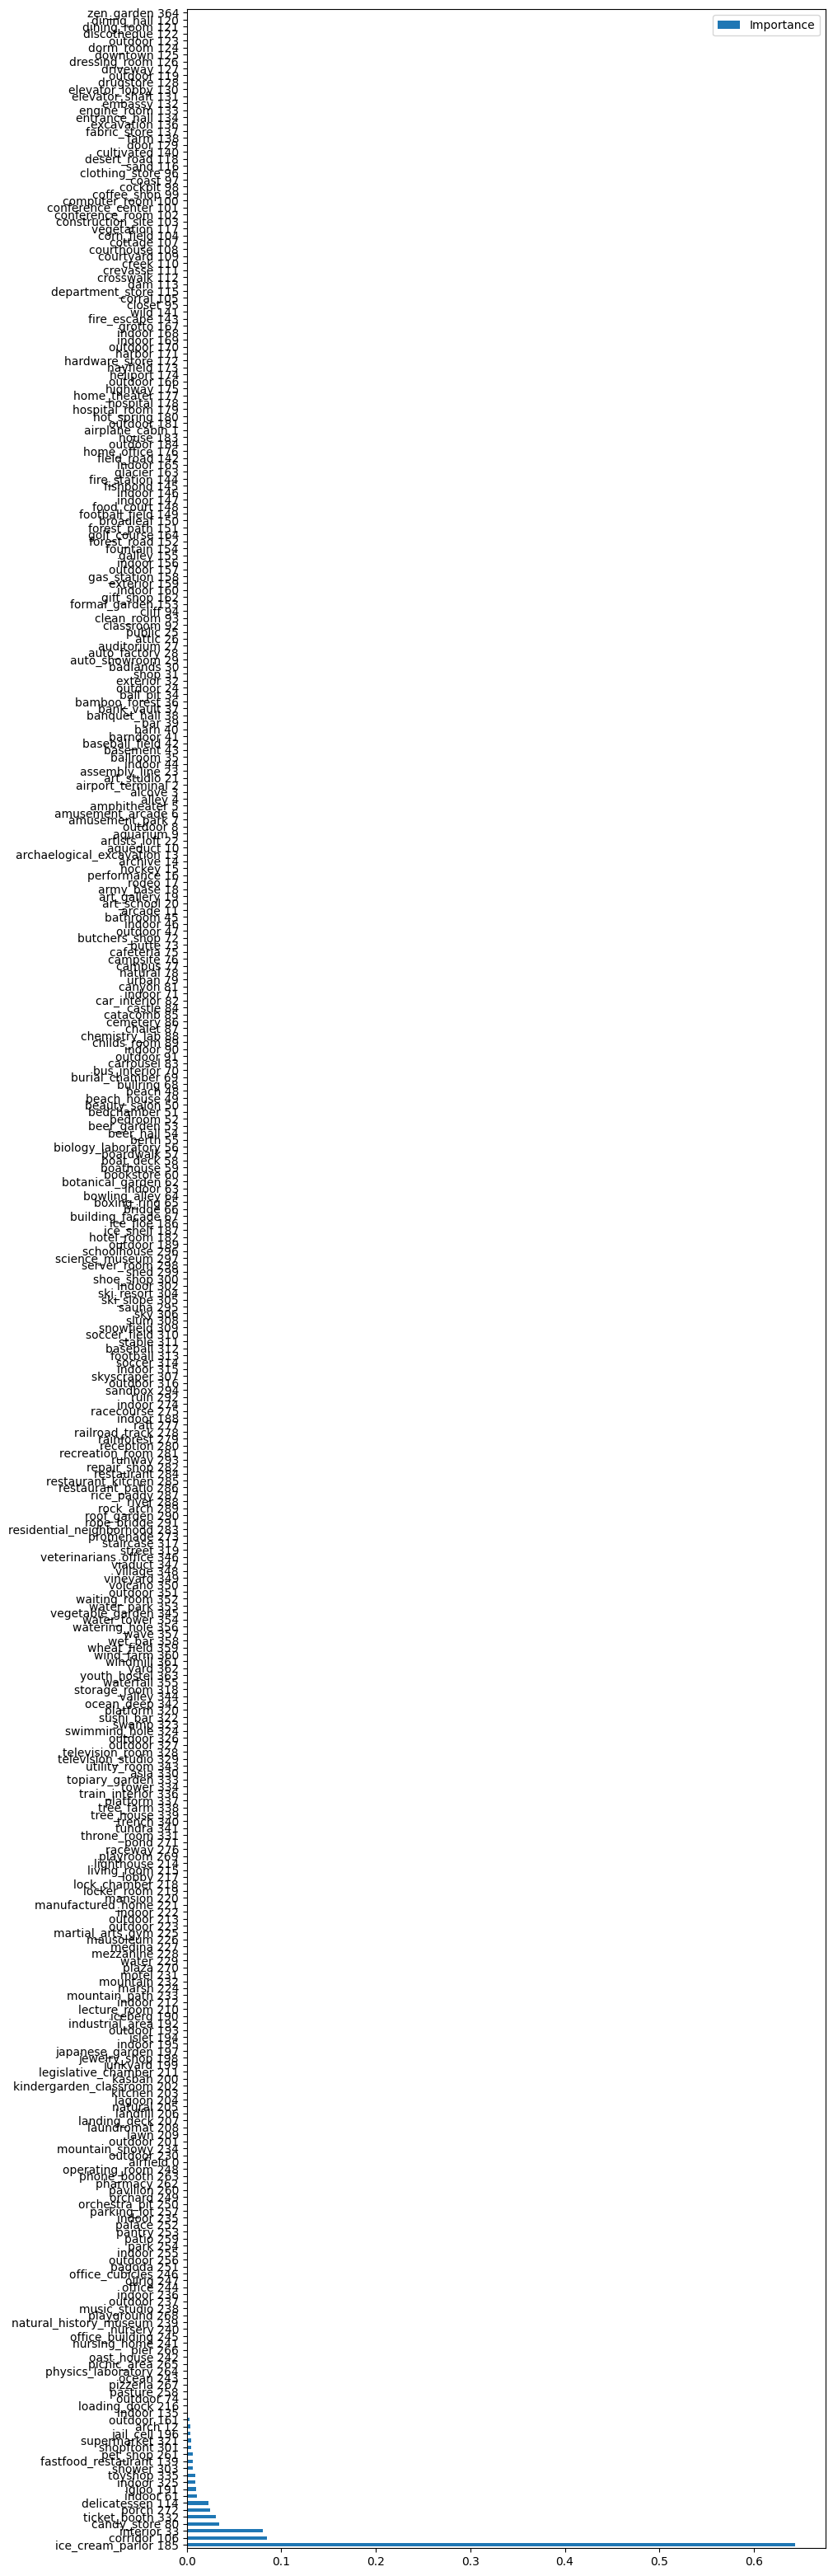

In [49]:
feat_importances = pd.DataFrame(clf.feature_importances_, 
                                index=scene_list, 
                                columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='barh', figsize=(10,40))

In [48]:
print(tpot.score(X_test, y_test))

0.9644524083114838


/Users/travistang/opt/anaconda3/envs/torch-scene/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:765: FutureWarning: sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.
  warnings.warn(
